<a href="https://colab.research.google.com/github/god05212/VGG19/blob/main/VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 사용한 데이터셋
> Face Mask Detection: 853 images belonging to 3 classes

- Larxel
- https://www.kaggle.com/andrewmvd
- https://www.kaggle.com/datasets/andrewmvd/face-mask-detection

# Basic Exploration

> 필요한 라이브러리를 import하고 데이터를 불러옵니다.

In [1]:
# 필요한 라이브러리 import
import numpy as np # 선형대수
import cv2
from scipy.spatial import distance
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

## Read dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Haar Cascade 얼굴 검출 모델 로드
face_model = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# 사전 훈련된 VGG19 모델 로드
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [4]:
# VGG19 모델의 레이어를 동결
for layer in vgg19.layers:
    layer.trainable = False
# 마스크 감지를 위한 Sequential 모델 생성
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))
# 모델 컴파일
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

> OpenCV를 사용하여 얼굴을 감지하고, 해당 얼굴 주변에 사각형 그리기

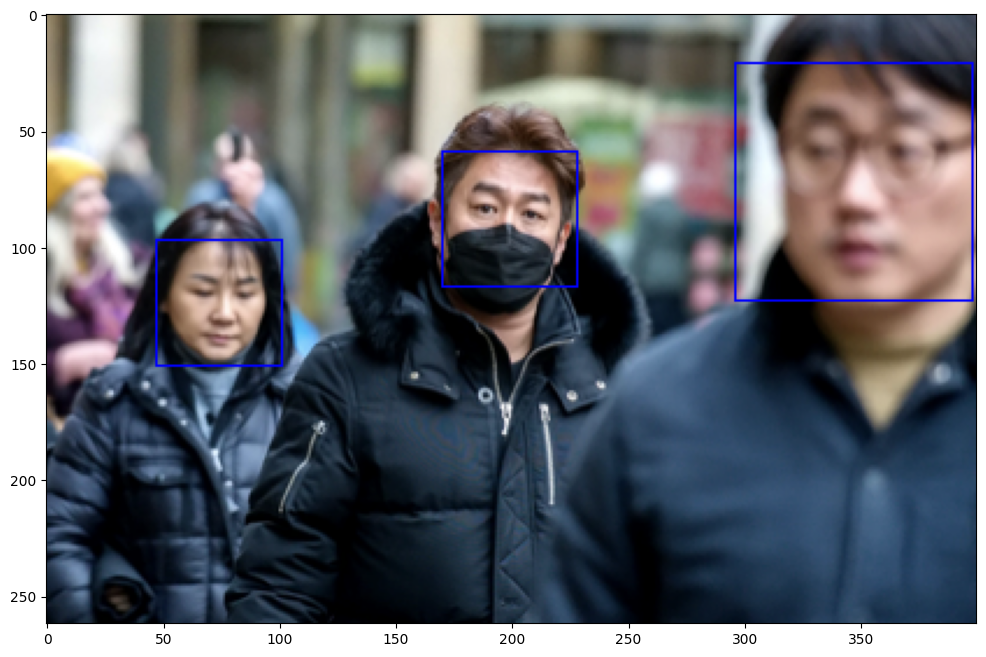

In [10]:
import matplotlib.pyplot as plt
# 이미지 불러오기
img = cv2.imread('/content/drive/MyDrive/archive (2)/images/maksssksksss244.png')

# 이미지를 그레이스케일로 변환
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

# 얼굴 감지
# 얼굴의 좌표와 크기를 리스트로 반환
faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)

# 컬러 이미지로 변환
out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# 감지된 얼굴 주변에 사각형 그리기
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)

# 결과 이미지를 표시
plt.figure(figsize=(12,12))
plt.imshow(out_img)

In [ ]:
# 데이터 디렉토리 설정
train_dir = '훈련_디렉토리_경로'
val_dir = '검증_디렉토리_경로'
test_dir = '테스트_디렉토리_경로'

# 훈련 및 검증 데이터에 대한 데이터 증강 생성
train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2)
val_datagen = ImageDataGenerator(rescale=1.0/255)

# 데이터 제너레이터 생성
train_generator = train_datagen.flow_from_directory(directory=train_dir, target_size=(128, 128), class_mode='categorical', batch_size=32)
val_generator = val_datagen.flow_from_directory(directory=val_dir, target_size=(128, 128), class_mode='categorical', batch_size=32)

# 모델 훈련
history = model.fit(x=train_generator, epochs=20, validation_data=val_generator)

# 테스트 데이터로 모델 평가
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(directory=test_dir, target_size=(128, 128), class_mode='categorical', batch_size=32)
test_results = model.evaluate(test_generator)

# 마스크 감지를 위한 테스트 이미지 로드
sample_mask_img = cv2.imread('테스트_이미지_경로')
sample_mask_img = cv2.resize(sample_mask_img, (128, 128))
sample_mask_img = np.expand_dims(sample_mask_img, axis=0) / 255.0

# 마스크 감지 실행
mask_result = model.predict(sample_mask_img)

# 사회적 거리두기 위반을 검출할 MIN_DISTANCE 정의
MIN_DISTANCE = 130

# 사회적 거리두기 위반을 검출할 이미지 로드
img = cv2.imread('이미지_경로')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_model.detectMultiScale(img_gray, scaleFactor=1.1, minNeighbors=4)

if len(faces) >= 2:
    label = [0 for i in range(len(faces)]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2], faces[j][:2])
            if dist < MIN_DISTANCE:
                label[i] = 1
                label[j] = 1

    new_img = img.copy()
    for i in range(len(faces):
        (x, y, w, h) = faces[i]
        crop = new_img[y:y+h, x:x+w]
        crop = cv2.resize(crop, (128, 128))
        crop = np.expand_dims(crop, axis=0) / 255.0
        mask_result = model.predict(crop)
        mask_label = "MASK" if mask_result[0][0] > mask_result[0][1] else "NO MASK"
        color = (0, 255, 0) if label[i] == 0 else (255, 0, 0)
        cv2.putText(new_img, mask_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        cv2.rectangle(new_img, (x, y), (x+w, y+h), color, 1)

    cv2.imshow("사회적 거리두기 및 마스크 검출", new_img)
    cv2.waitKey(0)
else:
    print("검출된 얼굴 수가 2개 미만입니다")

# 모델 저장
model.save('masknet.h5')